In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy.stats
plt.style.use("customstyle")

from statsmodels.stats.multitest import multipletests


colors = ["#" + x for x in ["000000","cf5c36","bcd696","7d4f7d","556B2F"]]
lcolors = ["#" + x for x in ["858585","e7af9c","e3eed3","cec5d3","90EE90"]] # light colors (for fill)

In [7]:
def stars_pvalue(p):
    if p <= 0.001:
        return '***'
    if p <= 0.01:
        return '**'
    if p <= 0.05:
        return '*'
    return 'ns'

width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)

In [8]:
# Load inference data
#outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12152"
outdir = "../simulations_output"

simul_infer = pd.read_csv(outdir + "/1-PBD/all_simulations_inference.csv")
simul_infer["combinaison"] = 10*simul_infer.param_vary + simul_infer.i_param_var

#summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")

n_rep = 1 + max(simul_infer.replicate)
n_val = max(simul_infer.i_param_var)
n_par = 5 
statsPBD = pd.read_csv(outdir + "/1-PBD/simulated_PDB_trees_stats.csv")

statsBD = pd.read_csv(outdir + "/2-CBD/simulated_BD_trees_stats.csv")

statsVarBD = pd.read_csv(outdir + "/3-varBD/simulated_varBD_trees_stats.csv")

PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]

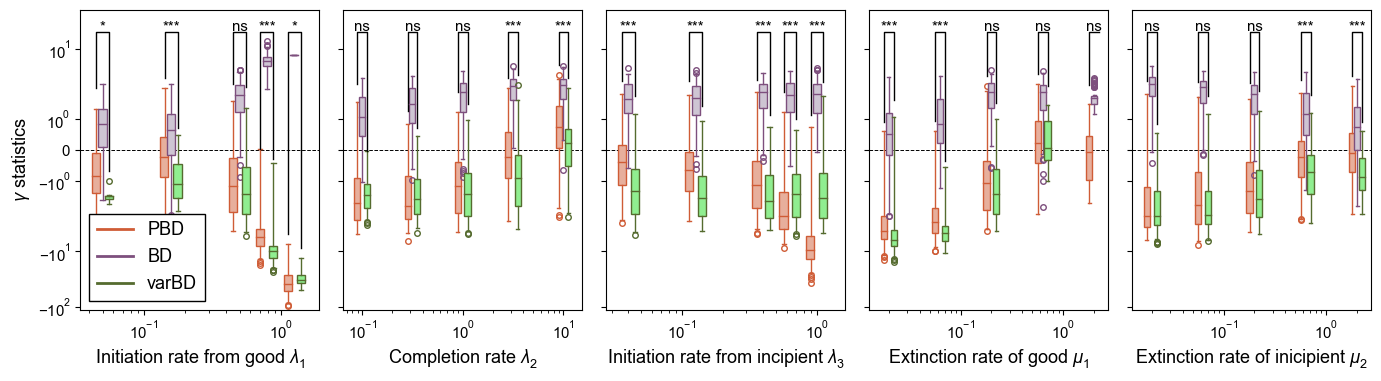

In [9]:
fig, axes = plt.subplots(1, 5, figsize = (14,4), sharey = True)

# Define boxplot styles 
c, lc = colors[1], lcolors[1] # for PBD boxplots
p = dict(color = c)
bp_stl_pbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[3], lcolors[3] # for BD boxplots
p = dict(color = c)
bp_stl_bd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[4], lcolors[4] # for varBD boxplots
p = dict(color = c)
bp_stl_varbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                    flierprops = dict(markeredgecolor = c, markersize = 4), 
                    medianprops = p, whiskerprops = p, patch_artist = True)

w = 0.06 # width of the boxplots
d = np.exp(0.11) # distance between boxplots (in log scale)

# Statistical tests
all_pvals = np.zeros((n_par, n_val))
all_mwu = np.zeros((n_par, n_val)) # Mann-Whitney U tests
n_trees = np.zeros((n_par, n_val, 2)) # Store the number of trees 

positions = np.zeros((n_par,n_val)) # x positions of the plots
maxval = np.zeros((n_par,n_val,2)) # maximum of gamma maxval[i_par, i_val, j] with j = 0 for PBD | 1 for BD

for i_par in range(n_par):
    axes[i_par].axhline(0, color = "k", lw = 0.7, ls = "--")

    boxes = [] # store the boxes data
    boxes_bd = []
    boxes_varbd = []
    for i_val in range(n_val):
        # select the corresponding lines in the different dataframes 
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                           (statsPBD.i_param_var == i_val + 1)]
        statsBD_config = statsBD.loc[(statsBD.param_vary == i_par+1) & 
                                               (statsBD.i_param_var == i_val + 1 )]
        statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par+1) & 
                                               (statsVarBD.i_param_var == i_val + 1 )]
        
        positions[i_par, i_val] = params[PBD_names[i_par]]

        gamma = statsPBD_config.gamma
        gamma = gamma.loc[(np.isfinite(gamma))] # remove nan
        maxval[i_par, i_val, 0] = np.max(gamma)

        gamma_bd = statsBD_config.gamma
        gamma_bd = gamma_bd.loc[(np.isfinite(gamma_bd))] # remove nan
        maxval[i_par, i_val, 1] = np.max(gamma_bd)
        
        gamma_varbd = statsVarBD_config.gamma
        gamma_varbd = gamma_varbd.loc[(np.isfinite(gamma_varbd))] # remove nan
        maxval[i_par, i_val, 1] = np.max(gamma_varbd)

        n_trees[i_par, i_val, :] = (len(gamma), len(gamma_bd))

        if len(gamma) > 0 and len(gamma_varbd) > 0:
            mwu = scipy.stats.mannwhitneyu(gamma, gamma_varbd) # Mann-Whitney U test
            all_mwu[i_par, i_val] = mwu.statistic
            all_pvals[i_par, i_val] = mwu.pvalue
        else:
            all_mwu[i_par, i_val] = np.nan
            all_pvals[i_par, i_val] = np.nan
        
        boxes.append(boxplot_stats(gamma, labels = None)[0])
        boxes_bd.append(boxplot_stats(gamma_bd, labels = None)[0])
        boxes_varbd.append(boxplot_stats(gamma_varbd, labels = None)[0])
    
    # Draw boxplots
    x = positions[i_par, :]
    bxp = axes[i_par].bxp(boxes, positions = x / d, widths = width(x / d, w), **bp_stl_pbd)
    bxp = axes[i_par].bxp(boxes_bd, positions = x, widths = width(x, w), **bp_stl_bd)
    bxp = axes[i_par].bxp(boxes_varbd, positions = x * d, widths = width(x * d, w), **bp_stl_varbd)

# Bonferroni correction for multiple test
bonferroni = multipletests(all_pvals.flatten(), method = "bonferroni")
p_vals_corrected = np.reshape(bonferroni[1], newshape= all_pvals.shape)

# Set ylim
ylim_lock = (-110, 50)

# Legend
axes[0].plot([],[], lw = 2, label = "PBD", color = bp_stl_pbd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "BD", color = bp_stl_bd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "varBD", color = bp_stl_varbd["whiskerprops"]["color"])
axes[0].legend()

# Add pvalues to the graph
caphi = 20 # Position of the upper cap for the signif. bars 
def symlog_d(y): # transform to have a dy constant in symlog scale
    if y > 0:
        return y * 1.5
    return y / 1.5

for i_par in range(5):
    for i_val in range(5):
        axes[i_par].text(x = positions[i_par, i_val], y = caphi*1.05, 
                         s = stars_pvalue(p_vals_corrected[i_par, i_val]),
                         ha = "center", size = 'small')

        # signif bars
        x = [positions[i_par, i_val] / d] * 2 + [positions[i_par, i_val] * d] * 2
        y = [symlog_d(maxval[i_par, i_val, 0]),caphi,caphi, symlog_d(maxval[i_par, i_val, 1])]
        axes[i_par].plot(x, y, lw = 1, color = "k")

    axes[i_par].set_xscale("log")

axes[0].set_xlabel("Initiation rate from good $\lambda_1$")
axes[1].set_xlabel("Completion rate $\lambda_2$")
axes[2].set_xlabel("Initiation rate from incipient $\lambda_3$")
axes[3].set_xlabel("Extinction rate of good $\mu_1$")
axes[4].set_xlabel("Extinction rate of inicipient $\mu_2$")

axes[0].set_ylabel("$\gamma$ statistics")
axes[0].set_yscale("symlog")
axes[0].set_ylim(ylim_lock)

plt.savefig("../fig/CBD_vs_BD_vs_varBD_gamma.pdf")

# Save the results of the MannWhitney_U_test
df = pd.DataFrame.from_dict(dict(param_vary = np.repeat(np.arange(1, 1+n_par), n_val), 
                                 i_param_var = np.tile(np.arange(1, 1+n_val), n_par),
                                 n_trees_pbd = n_trees[:,:,0].flatten(),
                                 n_trees_bd = n_trees[:,:,1].flatten(), 
                                 statistics = all_mwu.flatten(), 
                                 p_value = all_pvals.flatten(), 
                                 corrected_p_value = p_vals_corrected.flatten()))
df.to_csv("statistical_tests/Gamma_PBD_BD_varBD_MannWhitney_U_test.csv");

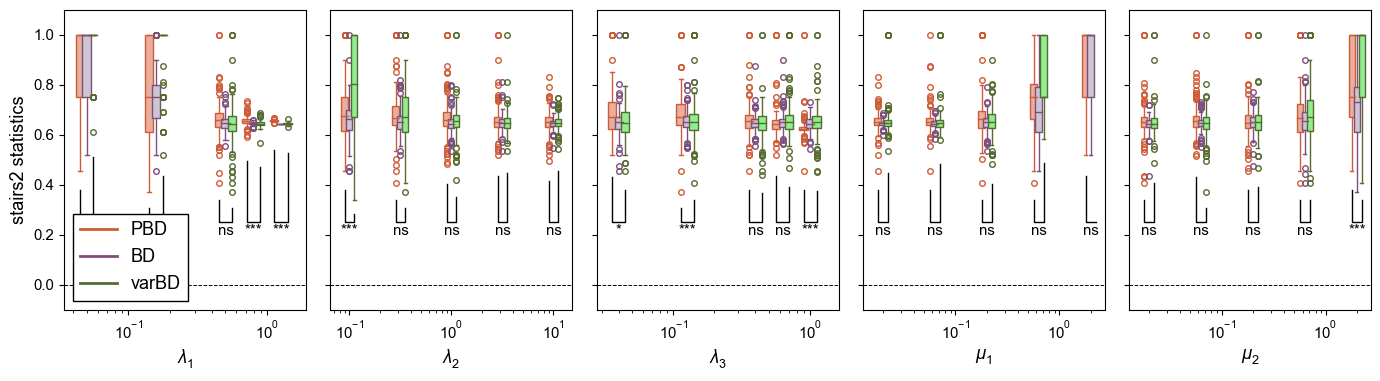

In [10]:
PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]

fig, axes = plt.subplots(1, 5, figsize = (14,4), sharey = True)

# Define boxplot styles 
c, lc = colors[1], lcolors[1] # for PBD boxplots
p = dict(color = c)
bp_stl_pbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[3], lcolors[3] # for BD boxplots
p = dict(color = c)
bp_stl_bd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[4], lcolors[4] # for varBD boxplots
p = dict(color = c)
bp_stl_varbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                    flierprops = dict(markeredgecolor = c, markersize = 4), 
                    medianprops = p, whiskerprops = p, patch_artist = True)

w = 0.06 # width of the boxplots
d = np.exp(0.11) # distance between boxplots (in log scale)

# Statistical tests
all_pvals = np.zeros((n_par, n_val))
all_mwu = np.zeros((n_par, n_val)) # Mann-Whitney U tests
n_trees = np.zeros((n_par, n_val, 2)) # Store the number of trees 

positions = np.zeros((n_par,n_val)) # x positions of the plots
minval = np.zeros((n_par,n_val,2)) # minimum of stairs2 minval[i_par, i_val, j] with j = 0 for PBD | 1 for BD

for i_par in range(n_par):
    axes[i_par].axhline(0, color = "k", lw = 0.7, ls = "--")

    boxes = [] # store the boxes data
    boxes_bd = []
    boxes_varbd = []
    for i_val in range(n_val):
        # select the corresponding lines in the different dataframes 
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                       (statsPBD.i_param_var == i_val + 1)]
        statsBD_config = statsBD.loc[(statsBD.param_vary == i_par+1) & 
                                     (statsBD.i_param_var == i_val + 1 )]
        statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par+1) & 
                                           (statsVarBD.i_param_var == i_val + 1 )]
        
        positions[i_par, i_val] = params[PBD_names[i_par]]

        stairs2 = statsPBD_config.stairs2
        stairs2 = stairs2.loc[(np.isfinite(stairs2))] # remove nan
        minval[i_par, i_val, 0] = np.min(stairs2)

        stairs2_bd = statsBD_config.stairs2
        stairs2_bd = stairs2_bd.loc[(np.isfinite(stairs2_bd))] # remove nan
        minval[i_par, i_val, 1] = np.min(stairs2_bd)
        
        stairs2_varbd = statsVarBD_config.stairs2
        stairs2_varbd = stairs2_varbd.loc[(np.isfinite(stairs2_varbd))] # remove nan
        minval[i_par, i_val, 1] = np.min(stairs2_varbd)

        n_trees[i_par, i_val, :] = (len(stairs2), len(stairs2_bd))

        if len(stairs2) > 0 and len(stairs2_varbd) > 0:
            mwu = scipy.stats.mannwhitneyu(stairs2, stairs2_varbd) # Mann-Whitney U test
            all_mwu[i_par, i_val] = mwu.statistic
            all_pvals[i_par, i_val] = mwu.pvalue
        else:
            all_mwu[i_par, i_val] = np.nan
            all_pvals[i_par, i_val] = np.nan
        
        boxes.append(boxplot_stats(stairs2, labels = None)[0])
        boxes_bd.append(boxplot_stats(stairs2_bd, labels = None)[0])
        boxes_varbd.append(boxplot_stats(stairs2_varbd, labels = None)[0])
    
    # Draw boxplots
    x = positions[i_par, :]
    bxp = axes[i_par].bxp(boxes, positions = x / d, widths = width(x / d, w), **bp_stl_pbd)
    bxp = axes[i_par].bxp(boxes_bd, positions = x, widths = width(x, w), **bp_stl_bd)
    bxp = axes[i_par].bxp(boxes_varbd, positions = x * d, widths = width(x * d, w), **bp_stl_varbd)

# Bonferroni correction for multiple test
bonferroni = multipletests(all_pvals.flatten(), method = "bonferroni")
p_vals_corrected = np.reshape(bonferroni[1], newshape= all_pvals.shape)

# Set ylim
ylim_lock = (-0.1, 1.1)

# Legend
axes[0].plot([],[], lw = 2, label = "PBD", color = bp_stl_pbd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "BD", color = bp_stl_bd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "varBD", color = bp_stl_varbd["whiskerprops"]["color"])
axes[0].legend(loc="best")

# Add pvalues to the graph
caphi = 0.25 # Position of the upper cap for the signif. bars 
def symlog_d(y): # transform to have a dy constant in symlog scale
    if y > 0:
        return y * 1.5
    return y / 1.5

for i_par in range(5):
    for i_val in range(5):
        axes[i_par].text(x = positions[i_par, i_val], y = caphi*0.8, 
                         s = stars_pvalue(p_vals_corrected[i_par, i_val]),
                         ha = "center", size = 'small')

        # signif bars
        x = [positions[i_par, i_val] / d] * 2 + [positions[i_par, i_val] * d] * 2
        y = [minval[i_par, i_val, 0]/1.2,caphi,caphi, minval[i_par, i_val, 1]/1.2]
        axes[i_par].plot(x, y, lw = 1, color = "k")

    axes[i_par].set_xscale("log")

axes[0].set_xlabel("$\lambda_1$")
axes[1].set_xlabel("$\lambda_2$")
axes[2].set_xlabel("$\lambda_3$")
axes[3].set_xlabel("$\mu_1$")
axes[4].set_xlabel("$\mu_2$")

axes[0].set_ylabel("stairs2 statistics")
axes[0].set_ylim(ylim_lock)

plt.savefig("../fig/CBD_vs_BD_vs_varBD_stairs2.pdf")

# Save the results of the MannWhitney_U_test
df = pd.DataFrame.from_dict(dict(param_vary = np.repeat(np.arange(1, 1+n_par), n_val), 
                                 i_param_var = np.tile(np.arange(1, 1+n_val), n_par),
                                 n_trees_pbd = n_trees[:,:,0].flatten(),
                                 n_trees_bd = n_trees[:,:,1].flatten(), 
                                 statistics = all_mwu.flatten(), 
                                 p_value = all_pvals.flatten(), 
                                 corrected_p_value = p_vals_corrected.flatten()))
df.to_csv("statistical_tests/stairs2_PBD_BD_varBD_MannWhitney_U_test.csv");

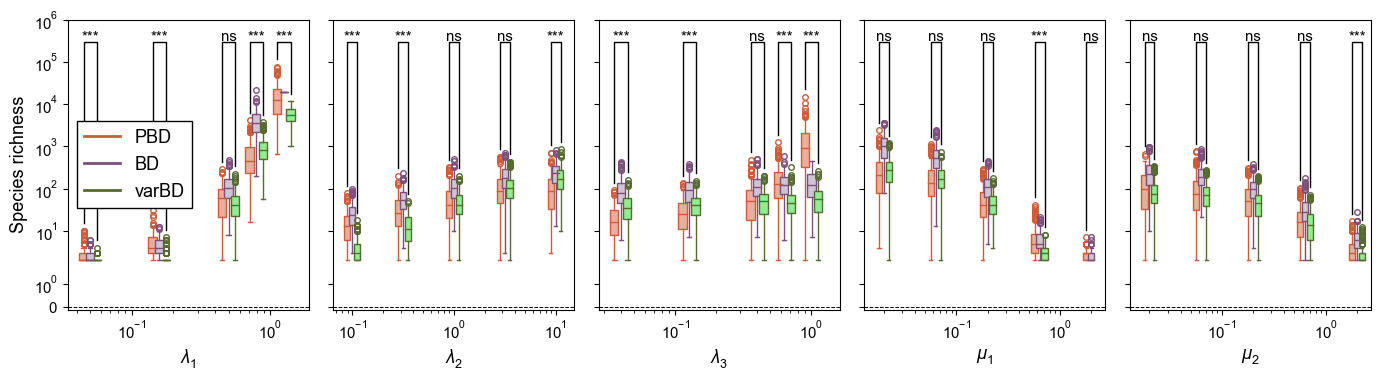

In [11]:
PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]

fig, axes = plt.subplots(1, 5, figsize = (14,4), sharey = True)

# Define boxplot styles 
c, lc = colors[1], lcolors[1] # for PBD boxplots
p = dict(color = c)
bp_stl_pbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[3], lcolors[3] # for BD boxplots
p = dict(color = c)
bp_stl_bd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[4], lcolors[4] # for varBD boxplots
p = dict(color = c)
bp_stl_varbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                    flierprops = dict(markeredgecolor = c, markersize = 4), 
                    medianprops = p, whiskerprops = p, patch_artist = True)

w = 0.06 # width of the boxplots
d = np.exp(0.11) # distance between boxplots (in log scale)

# Statistical tests
all_pvals = np.zeros((n_par, n_val))
all_mwu = np.zeros((n_par, n_val)) # Mann-Whitney U tests
n_trees = np.zeros((n_par, n_val, 2)) # Store the number of trees 

positions = np.zeros((n_par,n_val)) # x positions of the plots
maxval = np.zeros((n_par,n_val,2)) # maximum of SR maxval[i_par, i_val, j] with j = 0 for PBD | 1 for BD

for i_par in range(n_par):
    axes[i_par].axhline(0, color = "k", lw = 0.7, ls = "--")

    boxes = [] # store the boxes data
    boxes_bd = []
    boxes_varbd = []
    for i_val in range(n_val):
        # select the corresponding lines in the different dataframes 
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                           (statsPBD.i_param_var == i_val + 1)]
        statsBD_config = statsBD.loc[(statsBD.param_vary == i_par+1) & 
                                               (statsBD.i_param_var == i_val + 1 )]
        statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par+1) & 
                                               (statsVarBD.i_param_var == i_val + 1 )]
        
        positions[i_par, i_val] = params[PBD_names[i_par]]

        SR = statsPBD_config.SR
        SR = SR.loc[(np.isfinite(SR))] # remove nan
        maxval[i_par, i_val, 0] = np.max(SR)

        SR_bd = statsBD_config.SR
        SR_bd = SR_bd.loc[(np.isfinite(SR_bd))] # remove nan
        maxval[i_par, i_val, 1] = np.max(SR_bd)
        
        SR_varbd = statsVarBD_config.SR
        SR_varbd = SR_varbd.loc[(np.isfinite(SR_varbd))] # remove nan
        maxval[i_par, i_val, 1] = np.max(SR_varbd)

        n_trees[i_par, i_val, :] = (len(SR), len(SR_bd))

        if len(SR) > 0 and len(SR_varbd) > 0:
            mwu = scipy.stats.mannwhitneyu(SR, SR_varbd) # Mann-Whitney U test
            all_mwu[i_par, i_val] = mwu.statistic
            all_pvals[i_par, i_val] = mwu.pvalue
        else:
            all_mwu[i_par, i_val] = np.nan
            all_pvals[i_par, i_val] = np.nan
        
        boxes.append(boxplot_stats(SR, labels = None)[0])
        boxes_bd.append(boxplot_stats(SR_bd, labels = None)[0])
        boxes_varbd.append(boxplot_stats(SR_varbd, labels = None)[0])
    
    # Draw boxplots
    x = positions[i_par, :]
    bxp = axes[i_par].bxp(boxes, positions = x / d, widths = width(x / d, w), **bp_stl_pbd)
    bxp = axes[i_par].bxp(boxes_bd, positions = x, widths = width(x, w), **bp_stl_bd)
    bxp = axes[i_par].bxp(boxes_varbd, positions = x * d, widths = width(x * d, w), **bp_stl_varbd)

# Bonferroni correction for multiple test
bonferroni = multipletests(all_pvals.flatten(), method = "bonferroni")
p_vals_corrected = np.reshape(bonferroni[1], newshape= all_pvals.shape)

# Set ylim
ylim_lock = (-0.1, 1000000)

# Legend
axes[0].plot([],[], lw = 2, label = "PBD", color = bp_stl_pbd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "BD", color = bp_stl_bd["whiskerprops"]["color"])
axes[0].plot([],[], lw = 2, label = "varBD", color = bp_stl_varbd["whiskerprops"]["color"])
axes[0].legend()

# Add pvalues to the graph
caphi = 300000 # Position of the upper cap for the signif. bars 
def symlog_d(y): # transform to have a dy constant in symlog scale
    if y > 0:
        return y * 1.5
    return y / 1.5

for i_par in range(5):
    for i_val in range(5):
        axes[i_par].text(x = positions[i_par, i_val], y = caphi*1.05, 
                         s = stars_pvalue(p_vals_corrected[i_par, i_val]),
                         ha = "center", size = 'small')

        # signif bars
        x = [positions[i_par, i_val] / d] * 2 + [positions[i_par, i_val] * d] * 2
        y = [symlog_d(maxval[i_par, i_val, 0]),caphi,caphi, symlog_d(maxval[i_par, i_val, 1])]
        axes[i_par].plot(x, y, lw = 1, color = "k")

    axes[i_par].set_xscale("log")

axes[0].set_xlabel("$\lambda_1$")
axes[1].set_xlabel("$\lambda_2$")
axes[2].set_xlabel("$\lambda_3$")
axes[3].set_xlabel("$\mu_1$")
axes[4].set_xlabel("$\mu_2$")

axes[0].set_ylabel("Species richness")
axes[0].set_yscale("symlog")
axes[0].set_ylim(ylim_lock)

plt.savefig("../fig/CBD_vs_BD_vs_varBD_SR.pdf")

# Save the results of the MannWhitney_U_test
df = pd.DataFrame.from_dict(dict(param_vary = np.repeat(np.arange(1, 1+n_par), n_val), 
                                 i_param_var = np.tile(np.arange(1, 1+n_val), n_par),
                                 n_trees_pbd = n_trees[:,:,0].flatten(),
                                 n_trees_bd = n_trees[:,:,1].flatten(), 
                                 statistics = all_mwu.flatten(), 
                                 p_value = all_pvals.flatten(), 
                                 corrected_p_value = p_vals_corrected.flatten()))
df.to_csv("statistical_tests/SR_PBD_BD_varBD_MannWhitney_U_test.csv");

(0.0, 1.05)

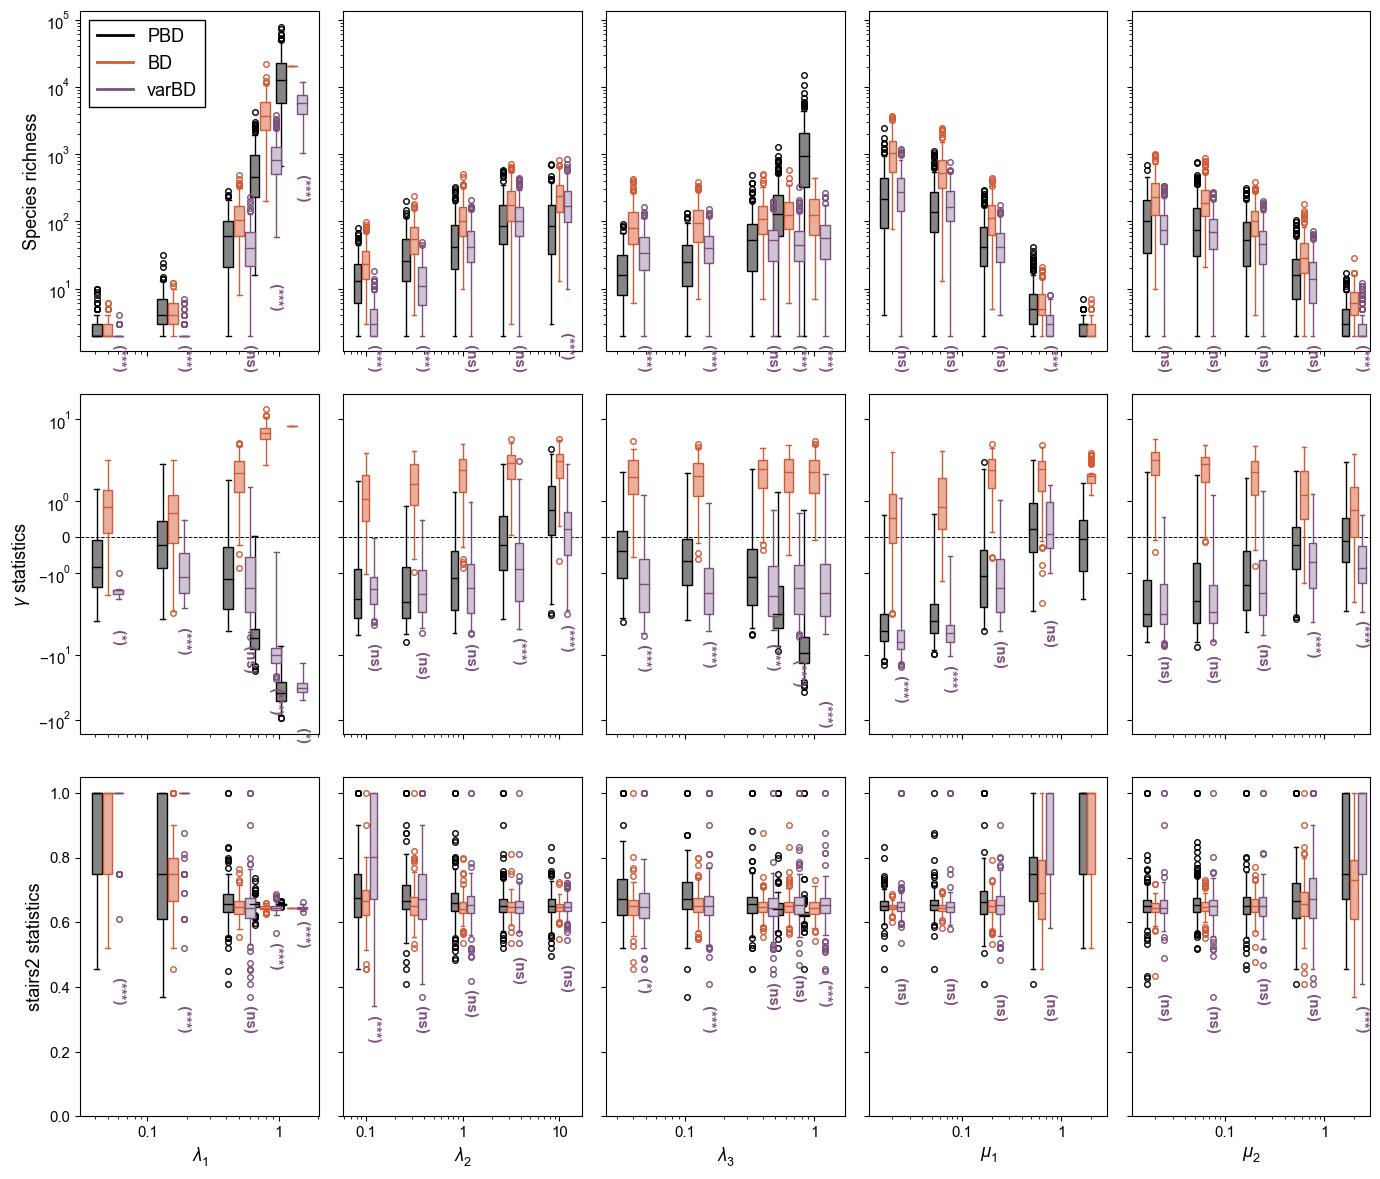

In [12]:
# All three graphics in one plot


# ----- GRAPHIC STYLE -----
# Statistics to plot
statistics = ["SR", "gamma", "stairs2"]
name_stats = dict(SR = "Species richness", gamma = "$\\gamma$ statistics", 
                  stairs2 = "stairs2 statistics") # Ylabel
scale = dict(SR = "log", gamma = "symlog", stairs2 = "linear")# y scale 


posit_bars = dict(SR = 0.5, gamma = -30, stairs2 = 0) # Position of the upper cap for the signif. bars 
# Define boxplot styles 
c, lc = colors[0], lcolors[0] # for PBD boxplots
p = dict(color = c)
bp_stl_pbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[1], lcolors[1] # for BD boxplots
p = dict(color = c)
bp_stl_bd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                  flierprops = dict(markeredgecolor = c, markersize = 4), 
                  medianprops = p, whiskerprops = p, patch_artist = True)

c, lc = colors[3], lcolors[3] # for varBD boxplots
p = dict(color = c)
bp_stl_varbd = dict(capprops = p, boxprops = dict(edgecolor = c, facecolor = lc), 
                    flierprops = dict(markeredgecolor = c, markersize = 4), 
                    medianprops = p, whiskerprops = p, patch_artist = True)

w = 0.075 # width of the boxplots
d = np.exp(0.19) # distance between boxplots (in log scale)



# ----- PLOT -----
fig, axes = plt.subplots(3, 5, figsize = (14, 12), sharex="col", sharey="row")
PBD_names = ["PBD." + s for s in ["l1", "l2", "l3", "mu1", "mu2"]]
def symlog_d(y): # transform to have a dy constant in symlog scale
    if y < 0:
        return y * 1.5
    return y / 1.5


for i_par in range(5):
    axes[0, i_par].set_xscale("log")

for i_stat, stat in enumerate(statistics):
    # Statistical tests
    all_pvals = np.zeros((n_par, n_val))
    all_mwu = np.zeros((n_par, n_val)) # Mann-Whitney U tests
    n_trees = np.zeros((n_par, n_val, 2)) # Store the number of trees 
    
    positions = np.zeros((n_par,n_val)) # x positions of the plots
    minval = np.zeros((n_par,n_val,3)) # minimum of stairs2 minval[i_par, i_val, j] with j = 0 for PBD | 1 for BD | 2 for varBD
    maxval = np.zeros_like(minval)
    for i_par in range(n_par):
        if stat == "gamma":
            axes[i_stat, i_par].axhline(0, color = "k", lw = 0.7, ls = "--")
    
        boxes = [] # store the boxes data
        boxes_bd = []
        boxes_varbd = []
        for i_val in range(n_val):
            # select the corresponding lines in the different dataframes 
            params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                     (simul_infer.i_param_var == i_val + 1) &
                                     (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
            statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                           (statsPBD.i_param_var == i_val + 1)]
            statsBD_config = statsBD.loc[(statsBD.param_vary == i_par+1) & 
                                         (statsBD.i_param_var == i_val + 1 )]
            statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par+1) & 
                                               (statsVarBD.i_param_var == i_val + 1 )]
            
            positions[i_par, i_val] = params[PBD_names[i_par]]

            stat_val = statsPBD_config[stat]
            stat_val = stat_val.loc[(np.isfinite(stat_val))] # remove nan
            minval[i_par, i_val, 0] = np.min(stat_val)
            maxval[i_par, i_val, 0] = np.max(stat_val)
            
            stat_val_bd = statsBD_config[stat]
            stat_val_bd = stat_val_bd.loc[(np.isfinite(stat_val_bd))] # remove nan
            minval[i_par, i_val, 1] = np.min(stat_val_bd)
            maxval[i_par, i_val, 1] = np.max(stat_val_bd)

            stat_val_varbd = statsVarBD_config[stat]
            stat_val_varbd = stat_val_varbd.loc[(np.isfinite(stat_val_varbd))] # remove nan
            minval[i_par, i_val, 2] = np.min(stat_val_varbd)
            maxval[i_par, i_val, 2] = np.max(stat_val_varbd)
            
            n_trees[i_par, i_val, :] = (len(stat_val), len(stat_val_bd))

            if len(stat_val) > 0 and len(stat_val_varbd) > 0:
                mwu = scipy.stats.mannwhitneyu(stat_val, stat_val_varbd) # Mann-Whitney U test
                all_mwu[i_par, i_val] = mwu.statistic
                all_pvals[i_par, i_val] = mwu.pvalue
            else:
                all_mwu[i_par, i_val] = np.nan
                all_pvals[i_par, i_val] = np.nan

            boxes.append(boxplot_stats(stat_val, labels = None)[0])
            boxes_bd.append(boxplot_stats(stat_val_bd, labels = None)[0])
            boxes_varbd.append(boxplot_stats(stat_val_varbd, labels = None)[0])

        # Draw boxplots
        x = positions[i_par, :]
        bxp = axes[i_stat, i_par].bxp(boxes, positions = x / d, widths = width(x / d, w), **bp_stl_pbd)
        bxp = axes[i_stat, i_par].bxp(boxes_bd, positions = x, widths = width(x, w), **bp_stl_bd)
        bxp = axes[i_stat, i_par].bxp(boxes_varbd, positions = x * d, widths = width(x * d, w), **bp_stl_varbd)

    axes[i_stat, 0].set_yscale(scale[stat])
    
    # Bonferroni correction for multiple test
    bonferroni = multipletests(all_pvals.flatten(), method = "bonferroni")
    p_vals_corrected = np.reshape(bonferroni[1], newshape= all_pvals.shape)

    # Add pvalues to the graph
    caphi = posit_bars[stat]
    if scale[stat] in ['log', 'symlog']:
        transfo = symlog_d
    else:
        transfo = lambda y:y - 0.03
    for i_par in range(5):
        for i_val in range(5):
            if not(np.isnan(minval[i_par, i_val,2])):
                axes[i_stat, i_par].text(x = positions[i_par, i_val]*d, 
                                         y = np.min(minval[i_par, i_val,:]), 
                                         s = "  (" + stars_pvalue(p_vals_corrected[i_par, i_val]) + ")", 
                                         ha = "center",
                                         va = "top", 
                                         size = "small",
                                         rotation = -90, 
                                         weight = "bold", 
                                         color = bp_stl_varbd["whiskerprops"]["color"])
            #axes[i_stat, i_par].text(x = positions[i_par, i_val], y = caphi*0.8, 
            #                 s = stars_pvalue(p_vals_corrected[i_par, i_val]),
            #                 ha = "center", size = 'small')
            #draw_bracket(ax = axes[i_stat, i_par],
            #             x1 = positions[i_par, i_val] / d,
            #             x2 = positions[i_par, i_val] * d,
            #             y1 = maxval[i_par, i_val, 0],
            #             y2 = maxval[i_par, i_val, 2], 
            #             s = stars_pvalue(p_vals_corrected[i_par, i_val]),
            #             text_style = dict(size = "small"))
            # signif bars
            #x = [positions[i_par, i_val] / d] * 2 + [positions[i_par, i_val] * d] * 2
            #y = [transfo(minval[i_par, i_val, 0]),caphi,caphi, transfo(minval[i_par, i_val, 1])]
            #axes[i_stat, i_par].plot(x, y, lw = 1, color = "k")


    axes[i_stat, 0].set_ylabel(name_stats[stat])
    
for i_par in range(5):
    xlimlock = axes[-1, i_par].get_xlim()
    axes[-1, i_par].set_xticks([0.1,1,10])    
    axes[-1, i_par].set_xticklabels(['0.1', '1', '10'])
    axes[-1, i_par].set_xlim(xlimlock)

# Legend
ax = axes[0,0]
ax.plot([],[], lw = 2, label = "PBD", color = bp_stl_pbd["whiskerprops"]["color"])
ax.plot([],[], lw = 2, label = "BD", color = bp_stl_bd["whiskerprops"]["color"])
ax.plot([],[], lw = 2, label = "varBD", color = bp_stl_varbd["whiskerprops"]["color"])
ax.legend(loc="best")

axes[-1,0].set_xlabel("$\lambda_1$")
axes[-1,1].set_xlabel("$\lambda_2$")
axes[-1,2].set_xlabel("$\lambda_3$")
axes[-1,3].set_xlabel("$\mu_1$")
axes[-1,4].set_xlabel("$\mu_2$")

axes[2, 0].set_ylim(0,1.05)


#plt.savefig("../fig/CBD_vs_BD_vs_varBD_stairs2.pdf")

In [13]:
# Plot stats with fill plots 
# Statistics to plot
statistics = ["SR", "gamma", "stairs2"]
models = ["PBD", "BD", "varBD"]
col_model = dict(PBD = [colors[0], lcolors[0]], 
                 BD = [colors[1], lcolors[1]], 
                 varBD = [colors[3], lcolors[3]]) 

qlow, qhigh = 0.1, 0.9 # lower and higher quantile to plot

name_stats = dict(SR = "Species richness", 
                  gamma = "$\\gamma$ statistics", 
                  stairs2 = "stairs2 statistics") # Ylabel
scale = dict(SR = "log", 
             gamma = "symlog", 
             stairs2 = "linear") # y scale 

# ---- Compute summary of stats ----
n_stats = len(statistics)

x = np.zeros((n_par, n_val))
median = np.zeros((n_par, n_val, n_stats, 3))
bottom_fill = np.zeros_like(median)
top_fill = np.zeros_like(median)
has_data = np.zeros((n_par, n_val, n_stats, 3), dtype = bool)
n_trees = np.zeros((n_par, n_val, n_stats, 3), dtype = int)

for i_par in range(n_par):
    for i_val in range(n_val):
        params = simul_infer.loc[(simul_infer.param_vary == i_par + 1) & 
                                 (simul_infer.i_param_var == i_val + 1) &
                                 (simul_infer.replicate == 0), PBD_names].to_dict("records")[0]
        statsPBD_config = statsPBD.loc[(statsPBD.param_vary == i_par + 1) & 
                                       (statsPBD.i_param_var == i_val + 1)]
        statsBD_config = statsBD.loc[(statsBD.param_vary == i_par+1) & 
                                     (statsBD.i_param_var == i_val + 1 )]
        statsVarBD_config = statsVarBD.loc[(statsVarBD.param_vary == i_par+1) & 
                                           (statsVarBD.i_param_var == i_val + 1 )]
        statsAll_config = (statsPBD_config, statsBD_config, statsVarBD_config)
        x[i_par, i_val] = params[PBD_names[i_par]]

        for i_stat, stat in enumerate(statistics):
            for i_model, stats_config in enumerate(statsAll_config):
                stat_val = stats_config[stat]
                stat_val = stat_val.loc[(np.isfinite(stat_val))] # remove nan
                n_trees[i_par, i_val, i_stat, i_model] = len(stat_val)
                if len(stat_val) > 0:
                    has_data[i_par, i_val, i_stat, i_model] = True
                    quant = np.quantile(stat_val, q = [qlow, 0.5, qhigh])

                    bottom_fill[i_par, i_val, i_stat, i_model] = quant[0]
                    median[i_par, i_val, i_stat, i_model] = quant[1]
                    top_fill[i_par, i_val, i_stat, i_model] = quant[2]
                else:
                    bottom_fill[i_par, i_val, i_stat, i_model] = np.nan
                    median[i_par, i_val, i_stat, i_model] = np.nan
                    top_fill[i_par, i_val, i_stat, i_model] = np.nan

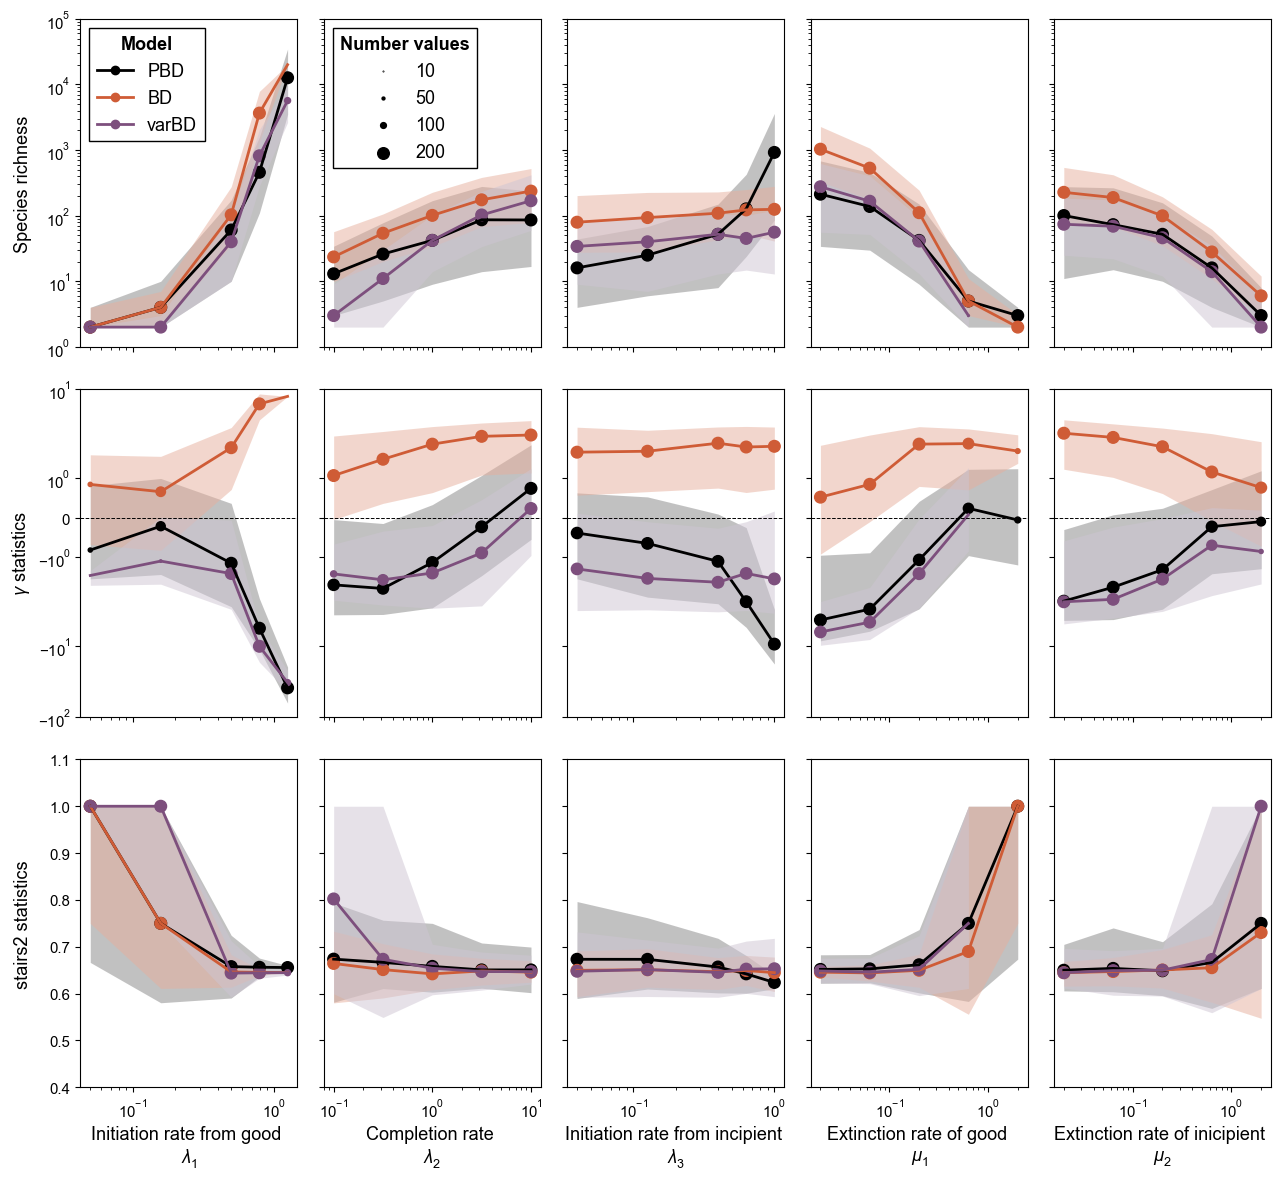

In [14]:
# ---- Plot figure ----
markersize = lambda n: 70*(n / 200)**2
fig, axes = plt.subplots(3, 5, figsize = (13, 12), sharex="col", sharey="row")

for i_stat, stat in enumerate(statistics):
    for i_par in range(n_val):
        ax = axes[i_stat, i_par]
        ax.set_xscale("log")

        for i_model, model in enumerate(models):
            ax.fill_between(x[i_par, :], 
                            bottom_fill[i_par, :, i_stat, i_model],
                            top_fill[i_par, :, i_stat, i_model], 
                            where = has_data[i_par, :, i_stat, i_model],
                            ec = col_model[model][1], 
                            fc = col_model[model][1],
                            lw = 0, 
                            alpha = 0.5)
        for i_model, model in enumerate(models):
            ax.plot(x[i_par, :], median[i_par, :, i_stat, i_model],
                    color = col_model[model][0], lw = 2)
            ax.scatter(x[i_par, :], median[i_par, :, i_stat, i_model],
                        color = col_model[model][0],marker = 'o', 
                        s = markersize(n_trees[i_par, :, i_stat, i_model]))

            
        if stat == "gamma":
            axes[i_stat, i_par].axhline(0, color = "k", lw = 0.7, ls = "--")
        
    axes[i_stat,0].set_yscale(scale[stat])
    axes[i_stat,0].set_ylabel(name_stats[stat])

legendstl = dict(loc = "upper left", title_fontproperties = dict(weight = 'bold'))

# Model legend
ax  = axes[0,0]
for i_model, model in enumerate(models):
    ax.plot([],[], marker = "o", color = col_model[model][0], lw = 2, label = model)
ax.legend(title = "Model", **legendstl)

# Markersize legend
ax = axes[0,1]
for n in [10,50,100,200]:
    ax.scatter([],[], color = "k", marker = "o",s = markersize(n), 
            label = str(n))
ax.legend(title = "Number values", **legendstl)

axes[-1,0].set_xlabel("Initiation rate from good \n$\lambda_1$")
axes[-1,1].set_xlabel("Completion rate \n$\lambda_2$")
axes[-1,2].set_xlabel("Initiation rate from incipient \n$\lambda_3$")
axes[-1,3].set_xlabel("Extinction rate of good \n$\mu_1$")
axes[-1,4].set_xlabel("Extinction rate of inicipient \n$\mu_2$")
axes[0,0].set_ylim(1,1e5)
axes[1,0].set_ylim(-100,10)
axes[2,0].set_ylim(0.4,1.1)
fig.align_labels()
plt.savefig("../fig/statistics_tree.pdf");